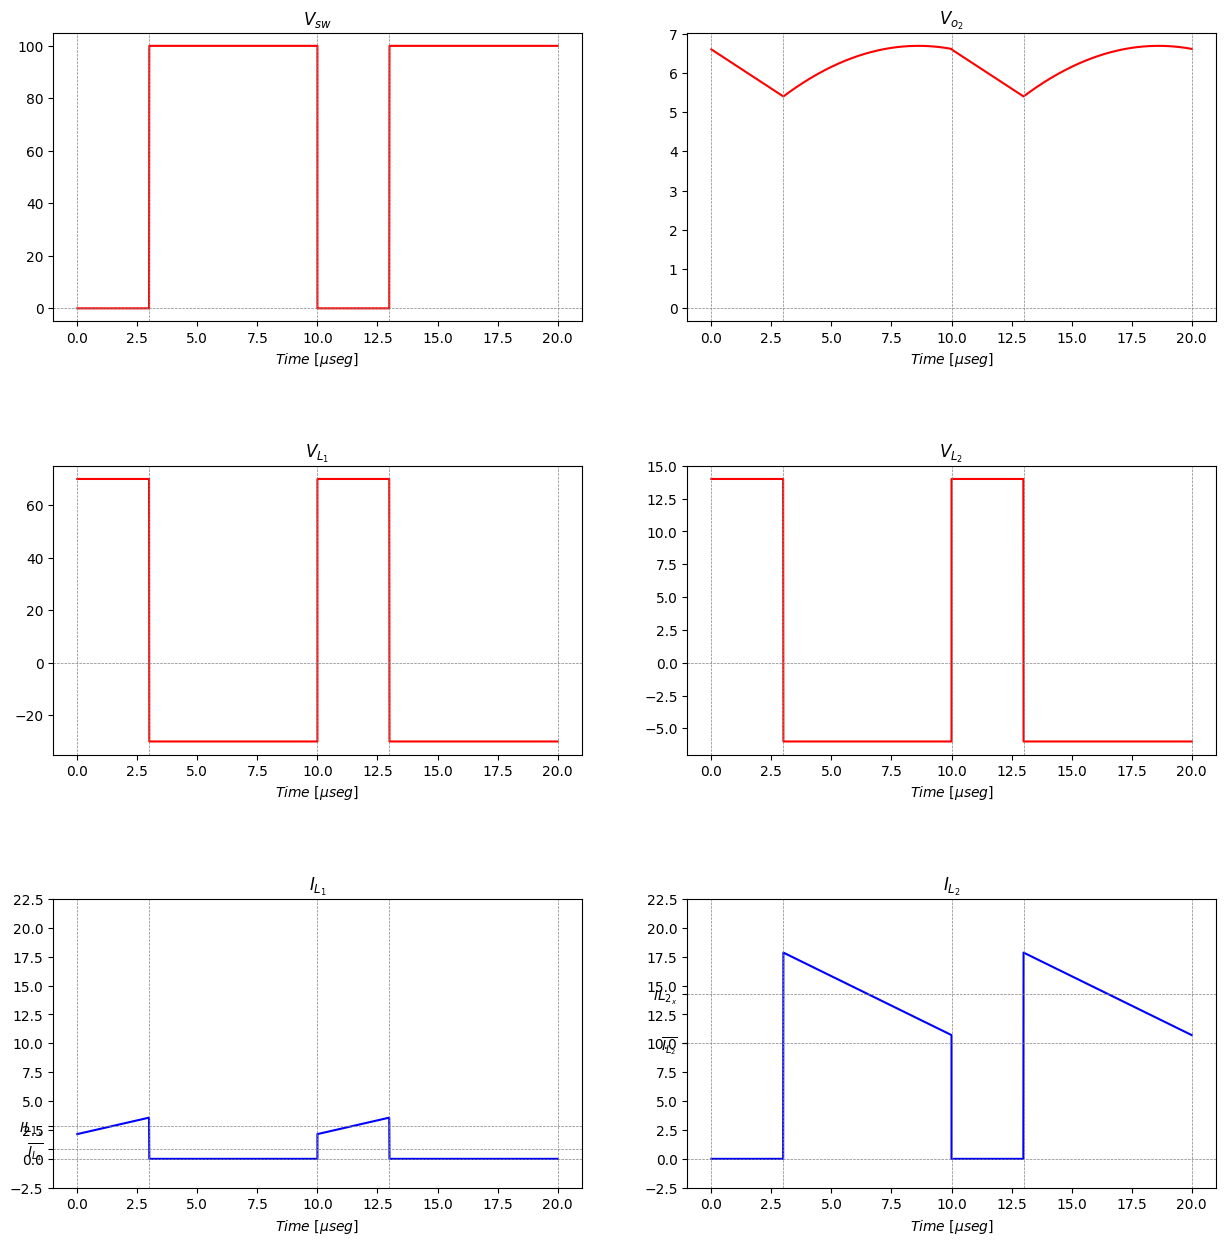

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import cumtrapz


def sim_flyback(Vd, D, Fs, Io2, Io3, L1, L2, L3, N1, N2, N3, C2, C3, graph):
    Ts = 1/Fs
    Vo2 = Vd*(N2/N1)*D/(1-D)
    Vo3 = Vd*(N3/N1)*D/(1-D)       #Vo3 will be in DCM, maybe find expression in DCM?
    
    #Currents
    Io2_mean = Io2
    Io3_mean = Io3
    Io1_mean = Io2*(N2/N1)              #Ignore Io3 current, it's small
    IL2_x = Io2_mean/(1-D)
    IL3_x = Io3_mean/(1-D)
    IL1_x = Io2_mean/(1-D)*(N2/N1)      #Ignore Io3 current, it's small

    Delta_IL1 = D*Ts*(Vd/L1)
    Delta_IL2 = (1-D)*Ts*(Vo2/L2)
    Delta_IL3 = (1-D)*Ts*(Vo3/L3)
    Io2_boundary = ((1-D)**2)*Ts*(Vo2/L2)/2
    Io3_boundary = ((1-D)**2)*Ts*(Vo3/L3)/2

    #Ripple
    Delta_Vo2 = (1/C2)*(Io2_mean*D*Ts)      #Assume that IL2 - Io2 > 0 during Toff 

    
    time_on = np.arange(0, D*Ts, 10E-9)
    time_off = np.arange(D*Ts, Ts, 10E-9)
    time = np.concatenate((time_on, time_off))
    labels = ["$V_L$", "$i_L$", "$V_C$", "$i_C$", "$V_{sw}$", "$i_{sw}$", "$V_D$", "$i_D$", "$V_d$", "$i_d$"]

    #Signals
    Vsw_on = 0
    Vsw_off = Vd + Vo2*N1/N2
    Vsw_time = np.concatenate((np.full(len(time_on), Vsw_on), np.full(len(time_off), Vsw_off)))


    VL1_on = Vd
    VL1_off = -(N1/N2)*Vo2
    VL1_time = np.concatenate((np.full(len(time_on), VL1_on), np.full(len(time_off), VL1_off)))

    VL2_on = (N2/N1)*Vd
    VL2_off = -Vo2
    VL2_time = np.concatenate((np.full(len(time_on), VL2_on), np.full(len(time_off), VL2_off)))

    #MISSING VO2

    IL1_on = IL1_x - Delta_IL1/2 + (Vd/L1)*(time_on) 
    IL1_off = 0 
    IL1_time = np.concatenate((IL1_on, np.full(len(time_off), IL1_off)))

    IL2_on = 0
    IL2_off = IL2_x + Delta_IL2/2 - (Vo2/L2)*(time_off - D*Ts) 
    IL2_time = np.concatenate((np.full(len(time_on), IL2_on), IL2_off))

    Vo2_on = Vo2 + Delta_Vo2/2 - Delta_Vo2*time_on/(D*Ts)
    Vo2_off = Vo2 - Delta_Vo2/2 + (1.46*(IL2_x + Delta_IL2/2 - Io2_mean)*(time_off-D*Ts) -(Vo2/L2)*(time_off-D*Ts)**2)/C2
    Vo2_time = np.concatenate((Vo2_on, Vo2_off))

    #Means
    IL1_mean = np.mean(IL1_time)
    IL2_mean = np.mean(IL2_time)
    #IL3_mean = np.mean(IL3_time)
    #Graph
    if graph == True:
        N_periods = 2
        signals = [Vsw_time, Vo2_time, VL1_time, VL2_time, IL1_time, IL2_time]
        labels = ["$V_{sw}$", "$V_{o_2}$", "$V_{L_1}$", "$V_{L_2}$", "$I_{L_1}$", "$I_{L_2}$"]

        #Two periods
        time = np.concatenate((time, time+Ts))
        time = time*1E6
        for i in range(len(signals)):
            signals[i] = np.concatenate((signals[i], signals[i]))

        fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(15, 15))
        #Adjust spacing
        fig.subplots_adjust(hspace=0.5)
        for i, ax in enumerate(axs.flatten()):
            my_color = ''
            if labels[i][1] == 'V':
                my_color = 'red'
            else:
                my_color ='blue'
            ax.plot(time, signals[i], color = my_color)
            ax.set_title(labels[i] + "")

            ax.set_xlabel("$Time\ [\mu seg]$")
            ax.grid(False)
            #Set the part we want to see
            #ax.set_xlim(0, N_periods*Ts)
            
            #Show 0
            ax.axhline(y= 0, linestyle='--', linewidth = 0.5, color='grey')
            #Draw vertical lines at the points of switching
            ax.axvline(x=0, linestyle='--', linewidth = 0.5,color='grey')
            for j in range(int(N_periods)):
                ax.axvline(x=(D*Ts + j*Ts)*1E6, linestyle='--', linewidth = 0.5,color='grey')
                ax.axvline(x=(1 + j)*Ts*1E6, linestyle='--', linewidth = 0.5,color='grey')

            
            #Special lines:
            if labels[i] == "$I_{L_1}$":
                # Get the existing ticks
                existing_ticks = ax.get_xticks()
                existing_ticks_labels = ax.get_xticklabels()
                ax.axhline(y= IL1_mean, linestyle='--', linewidth = 0.5, color='grey')
                ax.axhline(y= IL1_x, linestyle='--', linewidth = 0.5, color='grey')
                ax.set_yticks(list(existing_ticks) + [IL1_mean, IL1_x])
                ax.set_yticklabels(list(existing_ticks_labels) + ["$\overline{I_{L_1}}$", "$I{L_{1_x}}$"])
                #ax.xticks(rotation=45, ha='right')

            elif labels[i] == "$I_{L_2}$":
                # Get the existing ticks
                existing_ticks = ax.get_xticks()
                existing_ticks_labels = ax.get_xticklabels()
                ax.axhline(y= IL2_mean, linestyle='--', linewidth = 0.5, color='grey')
                ax.axhline(y= IL2_x, linestyle='--', linewidth = 0.5, color='grey')
                ax.set_yticks(list(existing_ticks) + [IL2_mean, IL2_x])
                ax.set_yticklabels(list(existing_ticks_labels) + ["$\overline{I_{L_2}}$", "$I{L_{2_x}}$"])
                #ax.xticks(rotation=45, ha='right')
                
    return 

#SIM TEST: 1P-2021 - B
Vd = 70
Fs = 100E3
Io2 = 10
Io3 = 1E-3          #Small so as to not bother everything

D = 0.3
N1 = 60
N2 = 12
N3 = N2
L1 = 147E-6
L2 = L1*(N2/N1)**2
L3 = L2
C2 = 25E-6
C3 = C2

sim_flyback(Vd, D, Fs, Io2, Io3, L1, L2, L3, N1, N2, N3, C2, C3, True)